In [1]:
%pip install pandas numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

# MovieLens data set
This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files links.csv, movies.csv, ratings.csv and tags.csv.

In [3]:
from zipfile import ZipFile
import os

# Check if the zip file already exists
if not os.path.exists('ml-latest-small.zip'):
    # Upload and extract the ml-latest-small.zip file
    !wget -q https://files.grouplens.org/datasets/movielens/ml-latest-small.zip

with ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Load the dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')

# Check basic data
print("Movies dataset shape:", movies.shape)
display(movies.head())
print("Ratings dataset shape:", ratings.shape)
display(ratings.head())
print("Tags dataset shape:", tags.shape)
display(tags.head())

Movies dataset shape: (9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Ratings dataset shape: (100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Tags dataset shape: (3683, 4)


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [4]:
# Check for missing values
print("Missing values in ratings:", ratings.isnull().sum())
print("Missing values in Movies data:", movies.isnull().sum())
print("Missing values in Tags data:", tags.isnull().sum())

Missing values in ratings: userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Missing values in Movies data: movieId    0
title      0
genres     0
dtype: int64
Missing values in Tags data: userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


In [5]:
# identify duplicates if any
print("Number of duplicate records in ratings:", ratings.duplicated().sum())
print("Number of duplicate records in movies:", movies.duplicated().sum())
print("Number of duplicate records in tags:", tags.duplicated().sum())

Number of duplicate records in ratings: 0
Number of duplicate records in movies: 0
Number of duplicate records in tags: 0


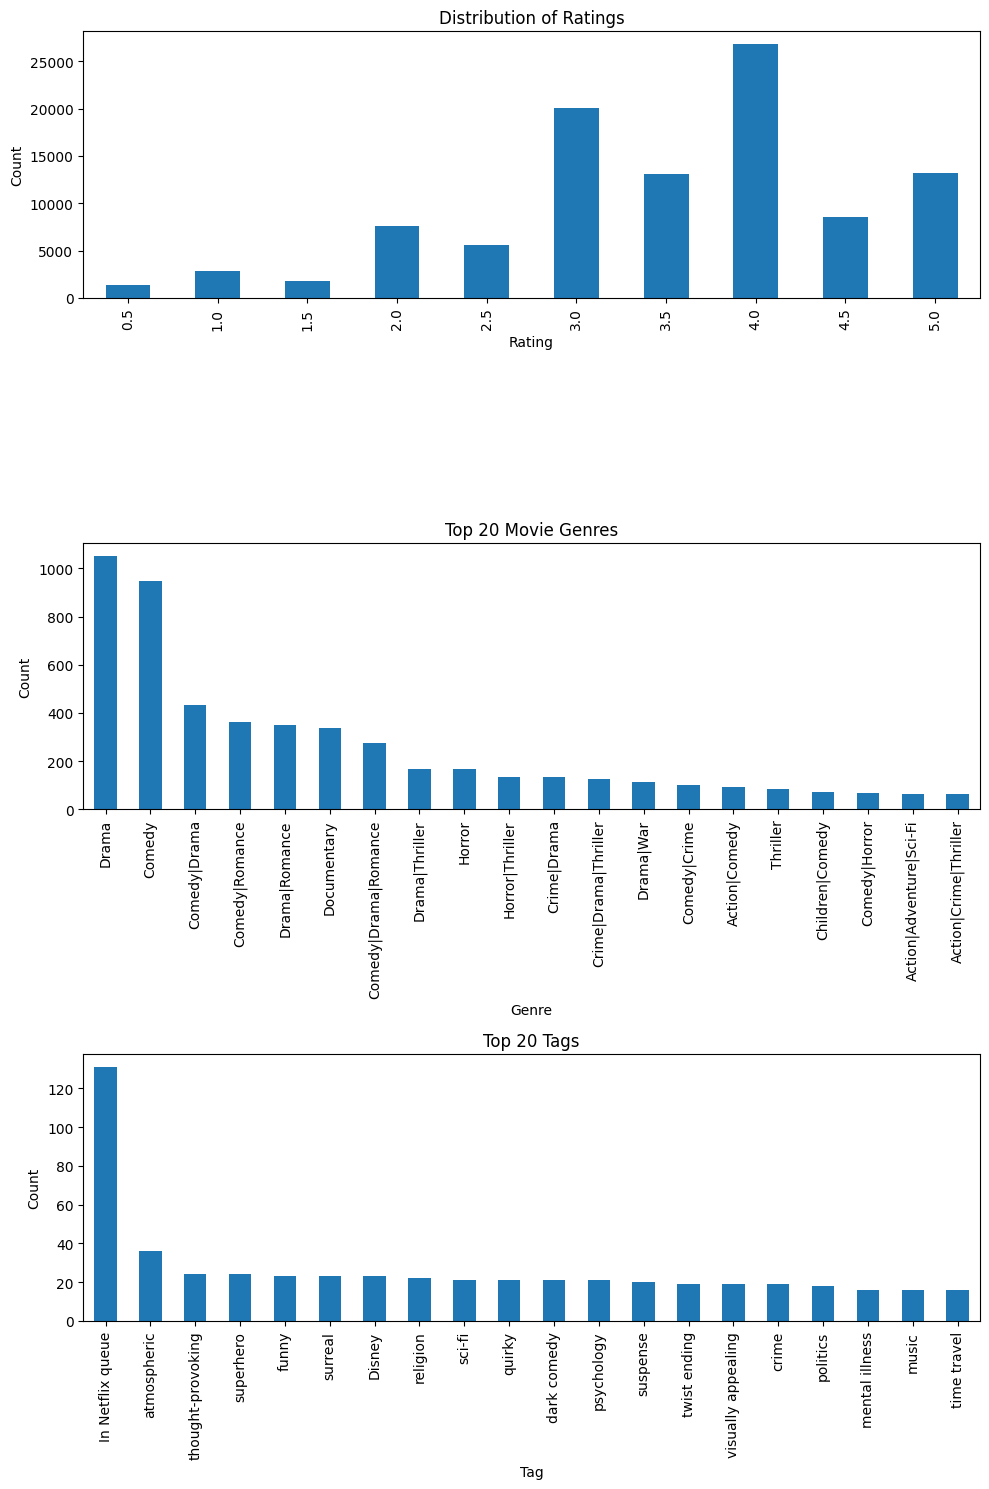

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Distribution of ratings
ratings['rating'].value_counts().sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title('Distribution of Ratings')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')

# Distribution of movies per genre
movies['genres'].value_counts().head(20).plot(kind='bar', ax=axes[1])
axes[1].set_title('Top 20 Movie Genres')
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Count')

# Distribution of tags
tags['tag'].value_counts().head(20).plot(kind='bar', ax=axes[2])
axes[2].set_title('Top 20 Tags')
axes[2].set_xlabel('Tag')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()


<Figure size 1400x800 with 0 Axes>

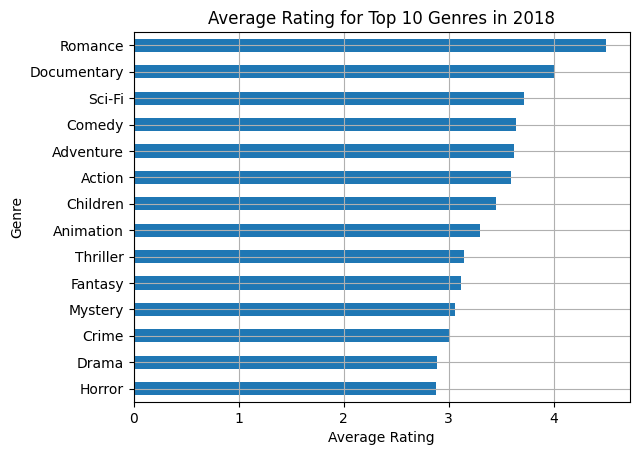

In [ ]:
# Extract year from the title
movies['year'] = movies['title'].str.extract(r'$(\d{4})$').astype(float)

# Explode genres into separate rows
movies_exploded = movies.assign(genres=movies['genres'].str.split('|')).explode('genres')

# Merge ratings with movies_exploded to get the year and genre for each rating
ratings_with_genres = ratings.merge(movies_exploded[['movieId', 'genres', 'year']], on='movieId')

# Group by year and genre and calculate the average rating
genre_year_avg_rating = ratings_with_genres.groupby(['year', 'genres'])['rating'].mean().reset_index()

# Get the genres by the number of ratings
top_genres = ratings_with_genres['genres'].value_counts().index

# Filter the data to include only the top 10 genres
top_genre_data = genre_year_avg_rating[genre_year_avg_rating['genres'].isin(top_genres)]

# Get the latest year available
latest_year = top_genre_data['year'].max()

# Filter data for the latest year
latest_year_data = top_genre_data[top_genre_data['year'] == latest_year]

# Plot the data
plt.figure(figsize=(14, 8))
latest_year_data.sort_values(by='rating', ascending=True).plot(kind='barh', x='genres', y='rating', legend=False)
plt.title(f'Average Rating for Top 10 Genres in {int(latest_year)}')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.grid(True)
plt.show()

In [8]:
# Create a user-item interaction matrix
user_item_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating',fill_value=0)
display(user_item_matrix.head())

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
output_path = r'intermediate_data\user_item_matrix.csv'
user_item_matrix.to_csv(output_path)